# Presentación

## Introducción

**TUIA - Aprendizaje Automático 1** - 2023

---

**Trabajo Práctico Integrador** - "Predicción de lluvia en Australia"

**Alumnos:**  

*   Brisa Menescaldi
*   Miguel Mussi



## Objetivo


Familiarizarse con la librería scikit-learn y las herramientas que brinda para el pre-procesamiento de datos, la implementación de modelos y la evaluación de métricas, y con TensorFlow para el entrenamiento de redes neuronales.

## Dataset



El dataset se llama weatherAUS.csv y contiene información climática de Australia de los últimos diez años, incluyendo si para el día siguiente llovió o no y la cantidad de lluvia en las columnas ‘RainTomorrow’ y ‘RainfallTomorrow’. El objetivo es la predicción de estas dos variables en función del resto de las características que se consideren adecuadas.

Tiene una columna ‘Location’ que indica la ciudad y el objetivo es predecir la condición de lluvia en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.

## Consignas





1. Armar grupos de hasta dos personas para la realización del trabajo práctico. Dar aviso al cuerpo docente del equipo. En caso de no tener compañero, informar al cuerpo docente.


2. Realizar un análisis descriptivo, que ayude a la comprensión del problema, de cada una de las variables involucradas en el problema detallando características, comportamiento y rango de variación.
Debe incluir:

> * Análisis y decisión sobre datos faltantes
* Visualización de datos (por ejemplo histogramas, scatterplots entre variables, diagramas de caja)
* ¿Está balanceado el dataset?
* Codificación de variables categóricas (si se van a utilizar para predicción).
* Matriz de correlación
* Selección de características para la predicción.
* Estandarización de datos.


3. Implementar la solución del problema de regresión con regresión lineal múltiple.

> * Probar con el método LinearRegression.
* Probar con métodos de gradiente descendiente.
* Probar con métodos de regularización (Lasso, Ridge, Elasticnet).
* Obtener las métricas adecuadas (entre R2 Score, MSE, RMSE, MAE, MAPE).


4. Implementar la solución del problema de clasificación con regresión logística.

> * Obtener las métricas adecuadas (entre Accuracy, precision, recall, F1 Score, ROC-AUC, entre otras).


5. Implementar las soluciones con una red neuronal.

> * Obtener las métricas adecuadas.


6. Mejorar la selección de hiperparámetros.

> * Probar validación cruzada.


7. MLOps (a definir).


8. Escribir una conclusión del trabajo

# Desarrollo

## Análisis exploratorio

In [1]:
#@title Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
#@title Sincronización con Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title DataFrame

# Path 1 - Referenciado a la carpeta de Drive
#file_path= '/content/drive/MyDrive/UNR/4 - Aprendizaje Automático (IA41)/Trabajo Práctico (AA1)/weatherAUS.csv'
#df_original = pd.read_csv(file_path, sep=',', engine='python')

# Path 2 - Mismo directorio
df_original = pd.read_csv('weatherAUS.csv', sep=',', engine='python')

In [4]:
df_original

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145407,145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,0.0
145408,145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145409,145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145410,145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0


In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        145412 non-null  int64  
 1   Date              145412 non-null  object 
 2   Location          145412 non-null  object 
 3   MinTemp           143928 non-null  float64
 4   MaxTemp           144159 non-null  float64
 5   Rainfall          142152 non-null  float64
 6   Evaporation       82658 non-null   float64
 7   Sunshine          75616 non-null   float64
 8   WindGustDir       135096 non-null  object 
 9   WindGustSpeed     135159 non-null  float64
 10  WindDir9am        134850 non-null  object 
 11  WindDir3pm        141186 non-null  object 
 12  WindSpeed9am      143645 non-null  float64
 13  WindSpeed3pm      142351 non-null  float64
 14  Humidity9am       142759 non-null  float64
 15  Humidity3pm       140907 non-null  float64
 16  Pressure9am       13

In [6]:
df_original.isna().sum()

Unnamed: 0              0
Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

In [7]:
df_original.describe()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,145412.000000,143928.000000,144159.000000,142152.000000,82658.000000,75616.000000,135159.000000,143645.000000,142351.000000,142759.000000,140907.000000,130351.000000,130388.000000,89542.000000,86076.000000,143646.000000,141805.000000,142153.000000
mean,72728.184393,12.195873,23.223176,2.361516,5.468616,7.611241,40.036564,14.044742,18.663164,68.877290,51.537432,1017.649277,1015.255184,4.447287,4.509770,16.992780,21.685249,2.361242
std,41990.722236,6.398018,7.118770,8.479338,4.193871,3.785612,13.607212,8.915610,8.810276,19.029576,20.796720,7.107132,7.037981,2.887161,2.720306,6.488045,6.936358,8.479084
min,0.000000,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,36362.750000,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,72727.500000,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,109093.250000,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,145458.000000,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


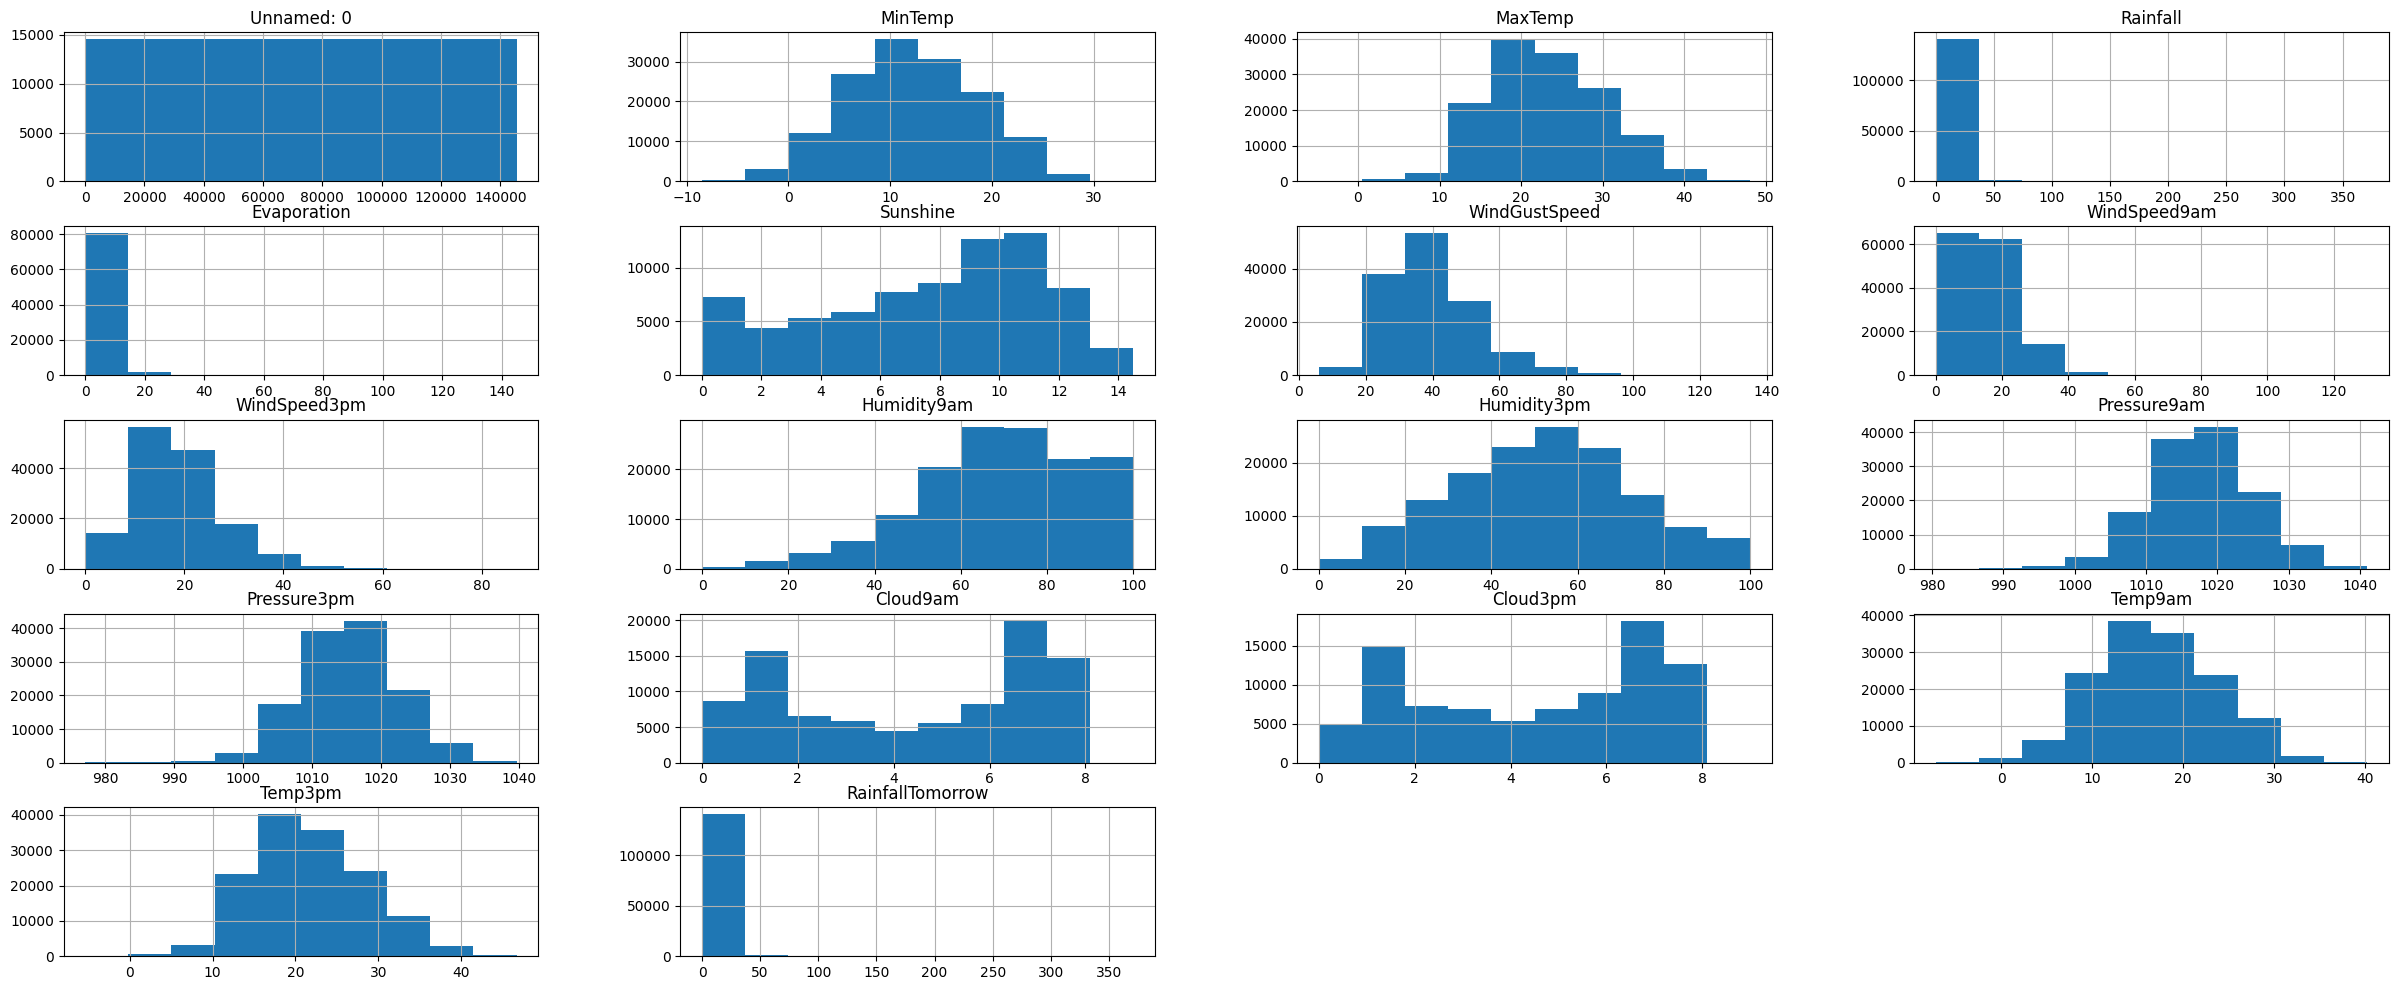

In [8]:
df_original.hist(figsize=(30,12))
plt.show()

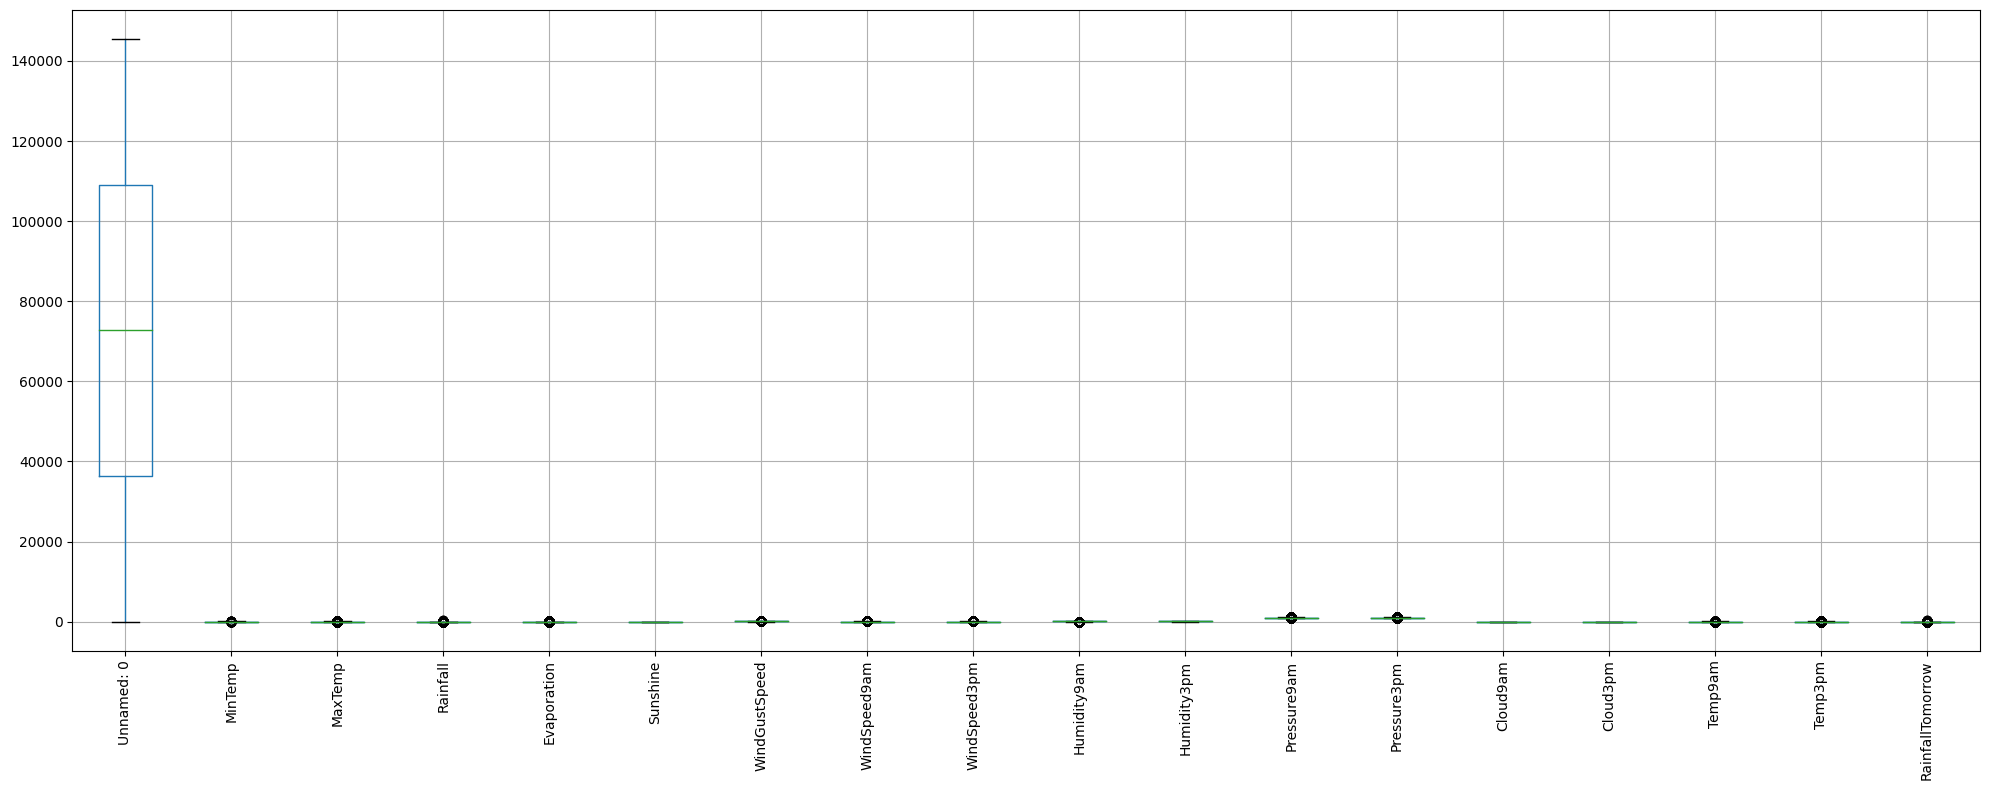

In [9]:
plt.figure(figsize=(20, 8))
df_original.boxplot(rot=90)
plt.tight_layout()  #para que las etiquetas no se superpongan
plt.show()

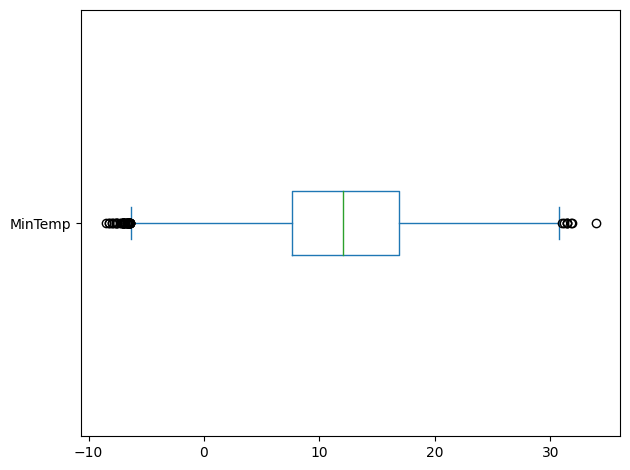

In [10]:
# Para ver de más cerca las columnas con menos rango
df_original['MinTemp'].plot(kind='box', vert=False)
plt.tight_layout()
plt.show()

## Limpieza del Dataset

Se desea analizar únicamente los registros correspondientes a las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.

In [11]:
# Copia del DF original con los registros correspondientes a la costa sureste
ciudades_a_conservar = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df = df_original[df_original['Location'].isin(ciudades_a_conservar)].copy()

In [12]:
# Eliminación de la primera columa
df = df.drop(['Unnamed: 0'], axis=1)

In [13]:
df['Location'] = df['Location'].astype('category')
#df['RainToday'] = df['RainToday'].astype('category')
#df['RanTomorrow'] = df['RainTomorrow'].astype('category')

In [14]:
# Agrupar por etiqueta y contar la frecuencia
Location_frec = df['Location'].value_counts()
Location_frec

Canberra            3435
Sydney              3343
Melbourne           3192
MelbourneAirport    3008
SydneyAirport       3008
Name: Location, dtype: int64

Tratamiento de datos nulos y faltantes

In [15]:
# Eliminación de registros con datos nulos/faltantes en variables booleanas
df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Se reemplaza valores nulos por las medias de cada columna que los contiene
df['MinTemp'].fillna(value=df['MinTemp'].mean(), inplace=True)
df['MaxTemp'].fillna(value=df['MaxTemp'].mean(), inplace=True)
df['Rainfall'].fillna(value=df['Rainfall'].mean(), inplace=True) # No quedan nulos acá
df['Evaporation'].fillna(value=df['Evaporation'].mean(), inplace=True)
df['Sunshine'].fillna(value=df['Sunshine'].mean(), inplace=True)
df['WindGustSpeed'].fillna(value=df['WindGustSpeed'].mean(), inplace=True)
df['WindSpeed9am'].fillna(value=df['WindSpeed9am'].mean(), inplace=True)
df['WindSpeed3pm'].fillna(value=df['WindSpeed3pm'].mean(), inplace=True)
df['Humidity9am'].fillna(value=df['Humidity9am'].mean(), inplace=True)
df['Humidity3pm'].fillna(value=df['Humidity3pm'].mean(), inplace=True)
df['Pressure9am'].fillna(value=df['Pressure9am'].mean(), inplace=True)
df['Pressure3pm'].fillna(value=df['Pressure3pm'].mean(), inplace=True)
df['Cloud9am'].fillna(value=df['Cloud9am'].mean(), inplace=True)
df['Cloud3pm'].fillna(value=df['Cloud3pm'].mean(), inplace=True)
df['Temp9am'].fillna(value=df['Temp9am'].mean(), inplace=True)
df['Temp3pm'].fillna(value=df['Temp3pm'].mean(), inplace=True)


Recategorización de variables

In [16]:
# Reemplazo de Yes/No
df['RainToday'] = df['RainToday'].replace('Yes',1)
df['RainToday'] = df['RainToday'].replace('No',0)
df['RainTomorrow'] = df['RainTomorrow'].replace('Yes',1)
df['RainTomorrow'] = df['RainTomorrow'].replace('No',0)
df['RainToday'] = df['RainToday'].astype(int)
df['RainTomorrow'] = df['RainTomorrow'].astype(int)

# Reemplazo de Coordenadas
mapeo_coord = {
    'E': 0, 'N': 90, 'W': 180, 'S': 270,
    'NNE': 45, 'ENE': 22.5, 'ESE': 337.5, 'SSE': 292.5,
    'SSO': 247.5, 'OSO': 202.5, 'ONO': 112.5, 'NNO': 67.5}
df['WindGustDir'] = df['WindGustDir'].map(mapeo_coord)
df['WindDir9am'] = df['WindDir9am'].map(mapeo_coord)
df['WindDir3pm'] = df['WindDir3pm'].map(mapeo_coord)
df.dropna(subset=['WindGustDir', 'WindDir9am', 'WindDir3pm'], inplace=True)

In [17]:
df.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64

In [18]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,...,3126.000000,3126.000000,3126.00000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000,3126.000000
mean,12.254766,22.111356,1.945489,5.091339,6.743510,148.826775,46.368202,158.845969,151.842610,20.328855,...,52.065233,1019.068308,1016.58928,4.917231,4.894807,16.030351,20.593556,0.197697,0.222009,2.314075
std,5.618470,6.035873,6.965085,3.206355,3.812125,108.479312,15.929919,100.389192,118.338446,12.143014,...,16.912588,7.074768,7.13721,2.511363,2.392929,5.465772,5.742197,0.398326,0.415664,7.882799
min,-6.800000,8.400000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,2.000000,...,8.000000,991.700000,985.50000,0.000000,0.000000,1.600000,7.700000,0.000000,0.000000,0.000000
25%,8.125000,17.600000,0.000000,2.600000,3.800000,90.000000,35.000000,90.000000,45.000000,11.000000,...,41.000000,1014.525000,1012.00000,3.000000,3.000000,11.900000,16.300000,0.000000,0.000000,0.000000
50%,12.200000,21.800000,0.000000,4.881041,7.000000,90.000000,43.000000,90.000000,90.000000,17.000000,...,52.000000,1019.100000,1016.70000,5.000000,5.000000,16.000000,20.300000,0.000000,0.000000,0.000000
75%,16.600000,25.975000,0.400000,6.800000,9.800000,270.000000,57.000000,270.000000,270.000000,28.000000,...,63.000000,1023.800000,1021.50000,7.000000,7.000000,20.100000,24.400000,0.000000,0.000000,0.600000
max,30.500000,46.400000,119.400000,23.800000,13.700000,337.500000,107.000000,337.500000,337.500000,67.000000,...,99.000000,1039.300000,1037.30000,8.000000,8.000000,35.500000,44.900000,1.000000,1.000000,119.400000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3126 entries, 31147 to 70368
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Date              3126 non-null   object  
 1   Location          3126 non-null   category
 2   MinTemp           3126 non-null   float64 
 3   MaxTemp           3126 non-null   float64 
 4   Rainfall          3126 non-null   float64 
 5   Evaporation       3126 non-null   float64 
 6   Sunshine          3126 non-null   float64 
 7   WindGustDir       3126 non-null   float64 
 8   WindGustSpeed     3126 non-null   float64 
 9   WindDir9am        3126 non-null   float64 
 10  WindDir3pm        3126 non-null   float64 
 11  WindSpeed9am      3126 non-null   float64 
 12  WindSpeed3pm      3126 non-null   float64 
 13  Humidity9am       3126 non-null   float64 
 14  Humidity3pm       3126 non-null   float64 
 15  Pressure9am       3126 non-null   float64 
 16  Pressure3pm       3

# Visualizaciones

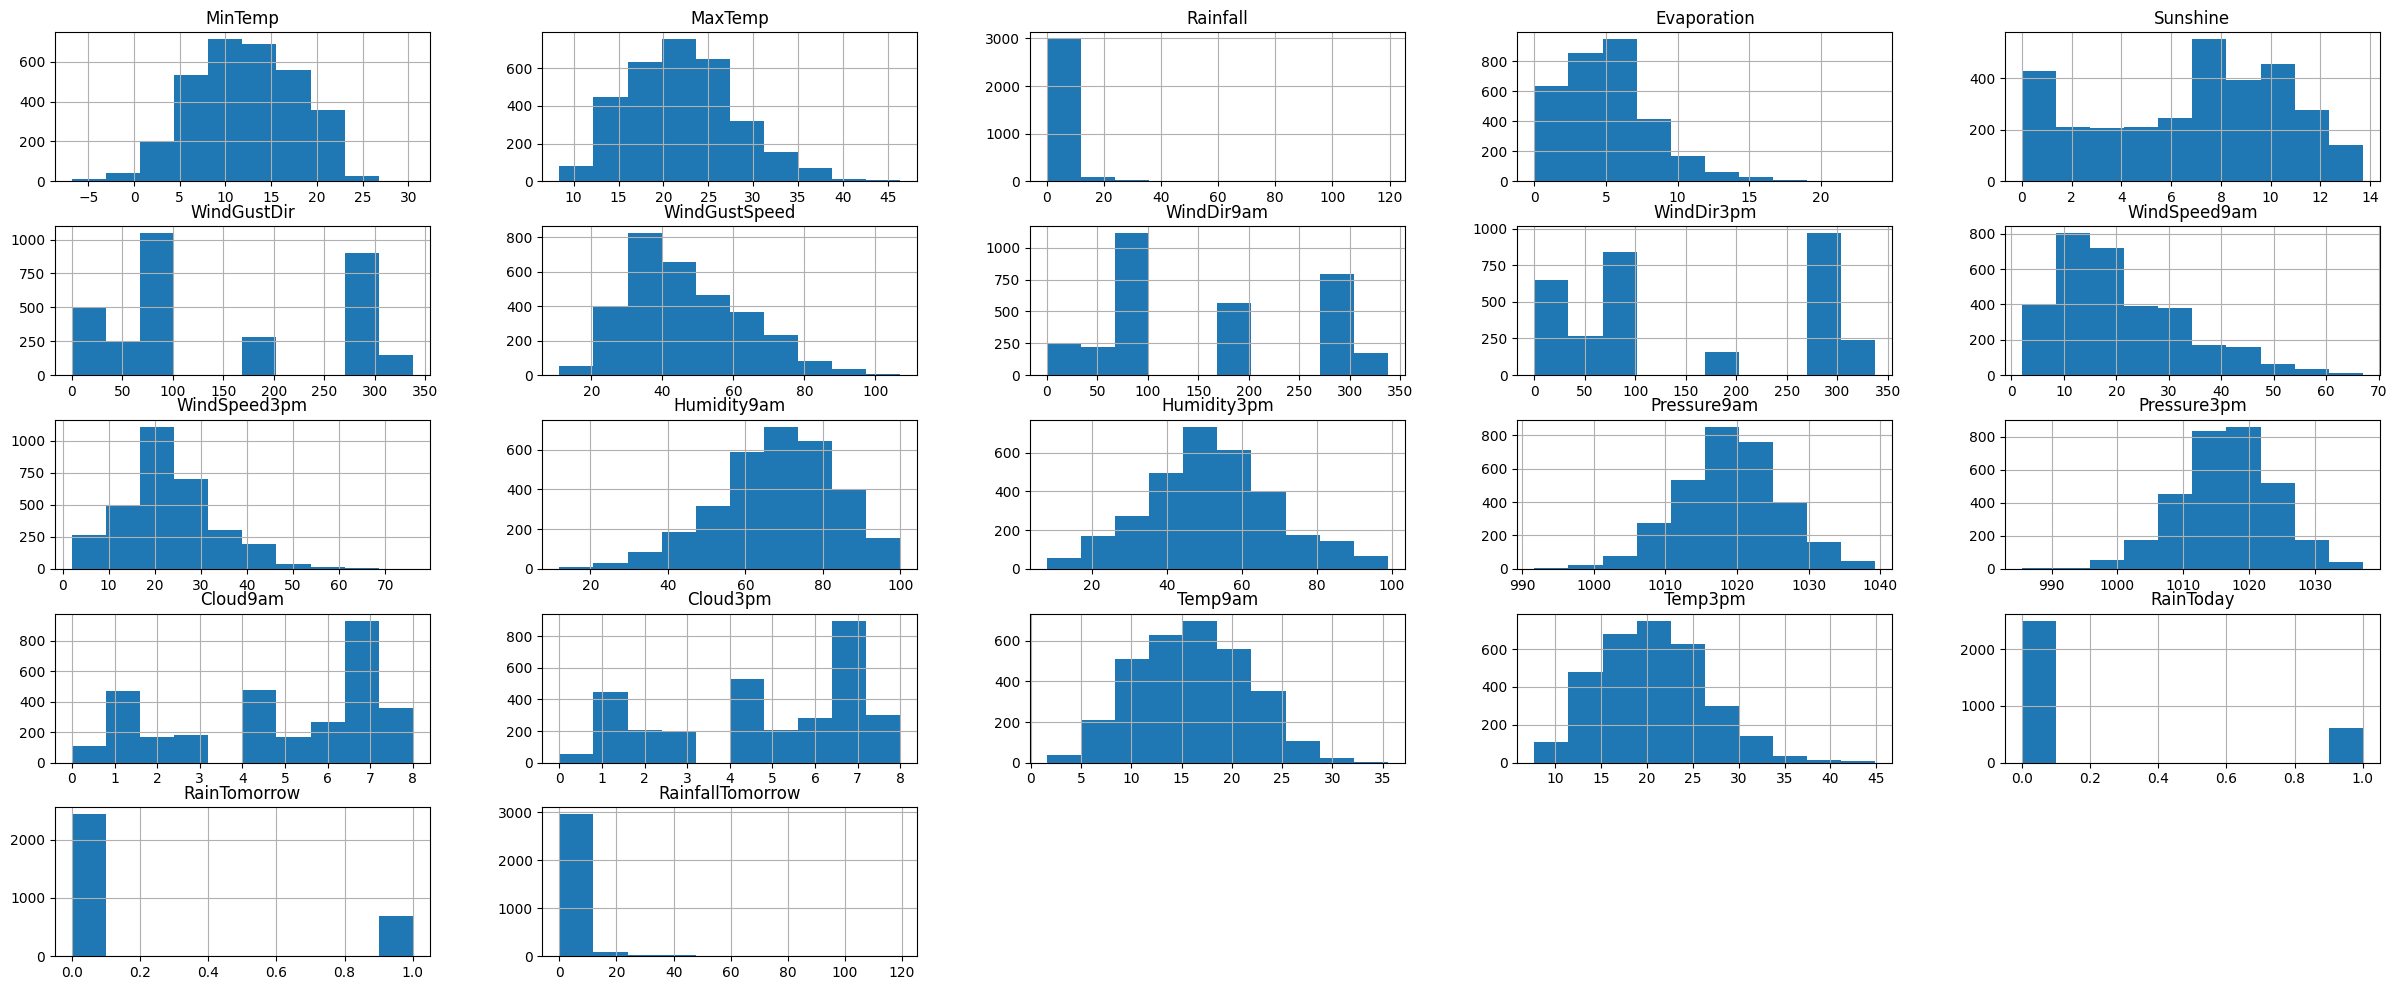

In [20]:
#@title Histogramas
df.hist(figsize=(30,12))
plt.show()

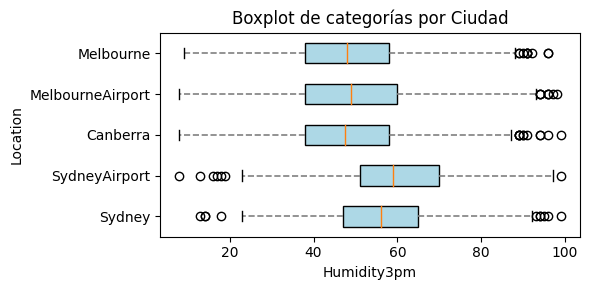

In [21]:
#@title Boxplot de atributos variables

# Variable a analizar (Disponibles)
# Date, Location, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine
# WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am
# WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm
# Cloud9am, Cloud3pm, Temp9am, Temp3pm, RainToday, RainTomorrow, RainfallTomorrow
target = 'Humidity3pm'

# Configuración de estilo y tamaño del gráfico
plt.figure(figsize=(6, 3))

# Crear el gráfico de boxplot con barrios en el eje vertical y precios en el eje horizontal
boxplot = plt.boxplot([df[df['Location'] == location][target] for location in df['Location'].unique()],
                      vert=False,  # Boxplots horizontales
                      patch_artist=True)  # Para personalizar colores de los cuadros

# Personalizar el color de los cuadros (box) y los bigotes (whisker)
for box in boxplot['boxes']:
    box.set(facecolor='lightblue')
for whisker in boxplot['whiskers']:
    whisker.set(color='gray', linewidth=1.2, linestyle='--')

# Etiquetas y título del gráfico
plt.yticks(range(1, len(df['Location'].unique()) + 1), df['Location'].unique())  # Etiquetas en el eje y
plt.xlabel(target)
plt.ylabel('Location')
plt.title('Boxplot de categorías por Ciudad')

# Desactivar notación científica en el eje horizontal (precios)
plt.ticklabel_format(axis='x', style='plain')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Correlaciones

In [22]:
df.corr()

<ipython-input-22-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
MinTemp,1.000000,0.697534,0.120356,0.599841,0.002409,0.024730,0.077818,0.077752,-0.018529,0.022049,...,0.128148,-0.417438,-0.354942,0.127613,0.016484,0.901213,0.665457,0.119744,0.145269,0.127948
MaxTemp,0.697534,1.000000,-0.055379,0.603949,0.399543,-0.106183,0.068994,-0.083029,-0.130010,-0.007371,...,-0.425959,-0.297231,-0.317646,-0.189549,-0.209222,0.859940,0.977669,-0.123557,-0.072890,-0.044427
Rainfall,0.120356,-0.055379,1.000000,-0.025523,-0.201648,0.089963,0.051551,0.147089,0.100973,0.038564,...,0.271451,-0.096522,-0.054076,0.166346,0.138837,0.044907,-0.058548,0.543153,0.253427,0.347252
Evaporation,0.599841,0.603949,-0.025523,1.000000,0.202780,0.018828,0.244844,0.070719,0.034029,0.207576,...,-0.210456,-0.332820,-0.280916,-0.050954,-0.085195,0.658542,0.562021,-0.125056,0.001947,0.009628
Sunshine,0.002409,0.399543,-0.201648,0.202780,1.000000,0.012499,-0.102080,0.003477,-0.014363,-0.072587,...,-0.587729,0.121518,0.089098,-0.612962,-0.644743,0.168984,0.427021,-0.249107,-0.425733,-0.302984
WindGustDir,0.024730,-0.106183,0.089963,0.018828,0.012499,1.000000,-0.123305,0.421255,0.624590,-0.082905,...,0.097819,0.027510,0.130358,0.039058,-0.047549,-0.047774,-0.121117,0.146670,0.010143,0.033798
WindGustSpeed,0.077818,0.068994,0.051551,0.244844,-0.102080,-0.123305,1.000000,-0.205064,-0.117655,0.717712,...,-0.113985,-0.391772,-0.416384,0.016318,0.143031,0.132929,0.047153,0.007991,0.173905,0.118733
WindDir9am,0.077752,-0.083029,0.147089,0.070719,0.003477,0.421255,-0.205064,1.000000,0.381753,-0.155954,...,0.140973,0.091017,0.184946,0.078024,-0.049464,0.017511,-0.091756,0.156294,-0.046331,0.054587
WindDir3pm,-0.018529,-0.130010,0.100973,0.034029,-0.014363,0.624590,-0.117655,0.381753,1.000000,-0.045072,...,0.115736,0.014130,0.131823,0.055088,-0.017149,-0.084450,-0.160879,0.145168,0.007099,0.054023
WindSpeed9am,0.022049,-0.007371,0.038564,0.207576,-0.072587,-0.082905,0.717712,-0.155954,-0.045072,1.000000,...,-0.144548,-0.193263,-0.191783,-0.028429,0.103545,0.055671,-0.010203,-0.009476,0.081326,0.046215


<ipython-input-23-325d5674752c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


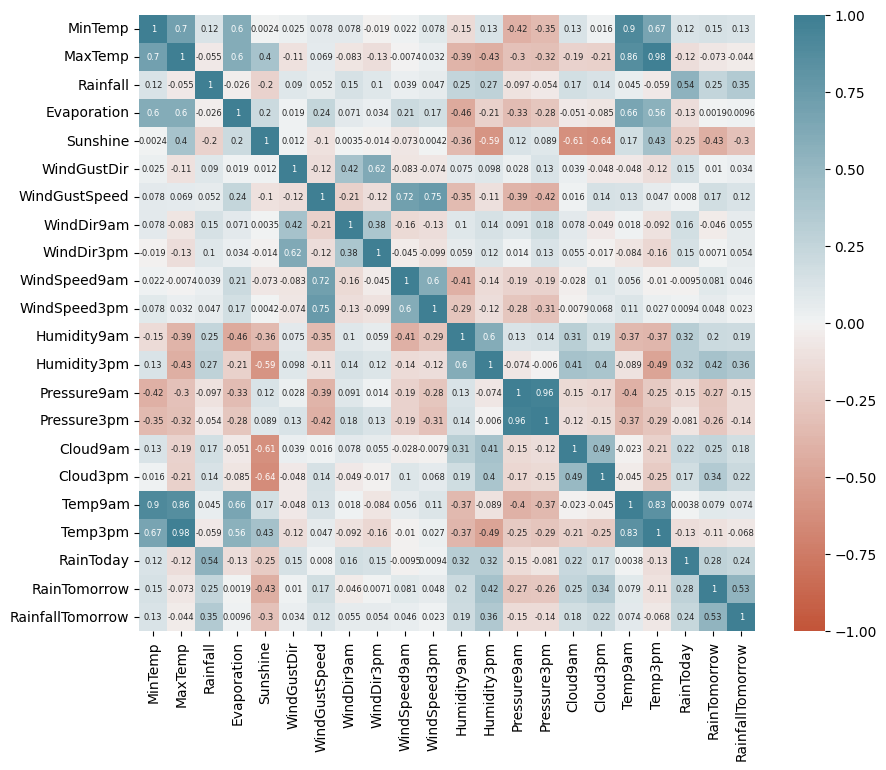

In [23]:
#@title Matriz de Correlación
corr = df.corr()
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
)
plt.show()

# Estandarización

In [24]:
# Reseteo de índices del dataframe
df = df.copy().reset_index(drop=True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2010-10-08,Sydney,13.8,19.5,0.0,4.6,9.5,337.5,35.0,45.0,...,56.0,1018.3384,1016.077778,6.000000,1.000000,16.5,19.1,0,0,0.0
1,2010-10-13,Sydney,16.7,23.9,0.4,7.0,2.8,45.0,39.0,180.0,...,64.0,1018.3384,1016.077778,7.000000,5.000000,17.8,22.9,0,1,2.0
2,2010-10-17,Sydney,9.9,24.0,0.0,6.6,12.1,180.0,41.0,180.0,...,30.0,1012.9000,1011.300000,4.737972,4.735349,14.7,23.3,0,0,0.0
3,2010-10-19,Sydney,14.0,19.0,3.8,6.4,0.8,292.5,37.0,292.5,...,53.0,1018.3384,1026.200000,8.000000,7.000000,14.7,17.1,1,0,0.2
4,2010-10-20,Sydney,12.9,20.3,0.2,3.0,10.9,22.5,37.0,180.0,...,57.0,1028.8000,1025.600000,3.000000,1.000000,16.9,19.8,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3121,2017-05-27,Melbourne,11.9,17.8,0.0,1.4,4.1,90.0,54.0,90.0,...,63.0,1017.5000,1012.000000,7.000000,7.000000,13.9,17.2,0,1,6.8
3122,2017-06-15,Melbourne,7.7,19.0,0.0,2.2,2.2,90.0,20.0,45.0,...,53.0,1027.7000,1024.800000,7.000000,6.000000,9.8,17.4,0,0,0.0
3123,2017-06-16,Melbourne,6.6,17.1,0.0,1.0,4.8,45.0,15.0,45.0,...,65.0,1026.4000,1023.800000,5.000000,3.000000,8.4,15.9,0,0,0.0
3124,2017-06-20,Melbourne,6.4,15.8,0.0,2.4,8.8,90.0,39.0,45.0,...,56.0,1028.1000,1024.500000,1.000000,7.000000,7.9,15.6,0,0,0.6


In [25]:
#@title Estandarización Z-score
df_sub = df.drop(['Location', 'Date'], axis=1) # Eliminación de variables no numéricas
scaler = StandardScaler()
df_std = scaler.fit_transform(df_sub)
df_std = pd.DataFrame(df_std, columns=df_sub.columns)
df_std

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0.275071,-0.432709,-0.279365,-0.153264,0.723201,1.739534,-0.713753,-1.134228,1.569119,-1.344927,...,0.232690,-0.103187,-0.071678,0.431217,-1.627892,0.085939,-0.260143,-0.496399,-0.534193,-0.293607
1,0.791309,0.296383,-0.221926,0.595370,-1.034631,-0.957264,-0.462613,0.210754,-1.093164,-1.097832,...,0.705787,-0.103187,-0.071678,0.829471,0.043967,0.323821,0.401730,-0.496399,1.871984,-0.039850
2,-0.419179,0.312953,-0.279365,0.470597,1.405344,0.287412,-0.337043,0.210754,1.188793,0.302374,...,-1.304872,-0.872014,-0.741204,-0.071391,-0.066648,-0.243436,0.471401,-0.496399,-0.534193,-0.293607
3,0.310674,-0.515560,0.266301,0.408211,-1.559356,1.324642,-0.588183,1.331572,1.188793,-0.274181,...,0.055279,-0.103187,1.346781,1.227725,0.879896,-0.243436,-0.608498,2.014510,-0.534193,-0.268231
4,0.114860,-0.300146,-0.250646,-0.652353,1.090509,-1.164710,-0.588183,0.210754,-1.283327,-0.768372,...,0.291827,1.375769,1.262701,-0.763545,-1.627892,0.159134,-0.138219,-0.496399,-0.534193,-0.293607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3121,-0.063153,-0.714403,-0.279365,-1.151441,-0.693559,-0.542372,0.479162,-0.685900,-0.522675,-0.027086,...,0.646650,-0.221712,-0.643110,0.829471,0.879896,-0.389825,-0.591080,-0.496399,1.871984,0.569169
3122,-0.810807,-0.515560,-0.279365,-0.901897,-1.192048,-0.542372,-1.655528,-1.134228,-0.522675,-0.933102,...,0.055279,1.220262,1.150594,0.829471,0.461932,-1.140067,-0.556245,-0.496399,-0.534193,-0.293607
3123,-1.006621,-0.830395,-0.279365,-1.276214,-0.509905,-0.957264,-1.969453,-1.134228,0.998630,-0.933102,...,0.764924,1.036481,1.010461,0.032963,-0.791963,-1.396248,-0.817511,-0.496399,-0.534193,-0.293607
3124,-1.042224,-1.045808,-0.279365,-0.839511,0.539547,-0.542372,-0.462613,-1.134228,-0.522675,-0.768372,...,0.232690,1.276810,1.108554,-1.560053,0.879896,-1.487741,-0.869764,-0.496399,-0.534193,-0.217480


In [26]:
df_std.describe().round(3)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,3126.000,3126.000,3126.000,3126.000,3126.000,3126.000,3126.000,3126.000,3126.000,3126.000,...,3126.000,3126.000,3126.000,3126.000,3126.000,3126.000,3126.000,3126.000,3126.000,3126.000
mean,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,...,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-3.392,-2.272,-0.279,-1.588,-1.769,-1.372,-2.221,-1.583,-1.283,-1.510,...,-2.606,-3.869,-4.357,-1.958,-2.046,-2.641,-2.246,-0.496,-0.534,-0.294
25%,-0.735,-0.748,-0.279,-0.777,-0.772,-0.542,-0.714,-0.686,-0.903,-0.768,...,-0.654,-0.642,-0.643,-0.764,-0.792,-0.756,-0.748,-0.496,-0.534,-0.294
50%,-0.010,-0.052,-0.279,-0.066,0.067,-0.542,-0.211,-0.686,-0.523,-0.274,...,-0.004,0.004,0.016,0.033,0.044,-0.006,-0.051,-0.496,-0.534,-0.294
75%,0.774,0.640,-0.222,0.533,0.802,1.117,0.668,1.107,0.999,0.632,...,0.647,0.669,0.688,0.829,0.880,0.745,0.663,-0.496,-0.534,-0.217
max,3.248,4.025,16.866,5.836,1.825,1.740,3.807,1.780,1.569,3.844,...,2.776,2.860,2.902,1.228,1.298,3.563,4.234,2.015,1.872,14.856


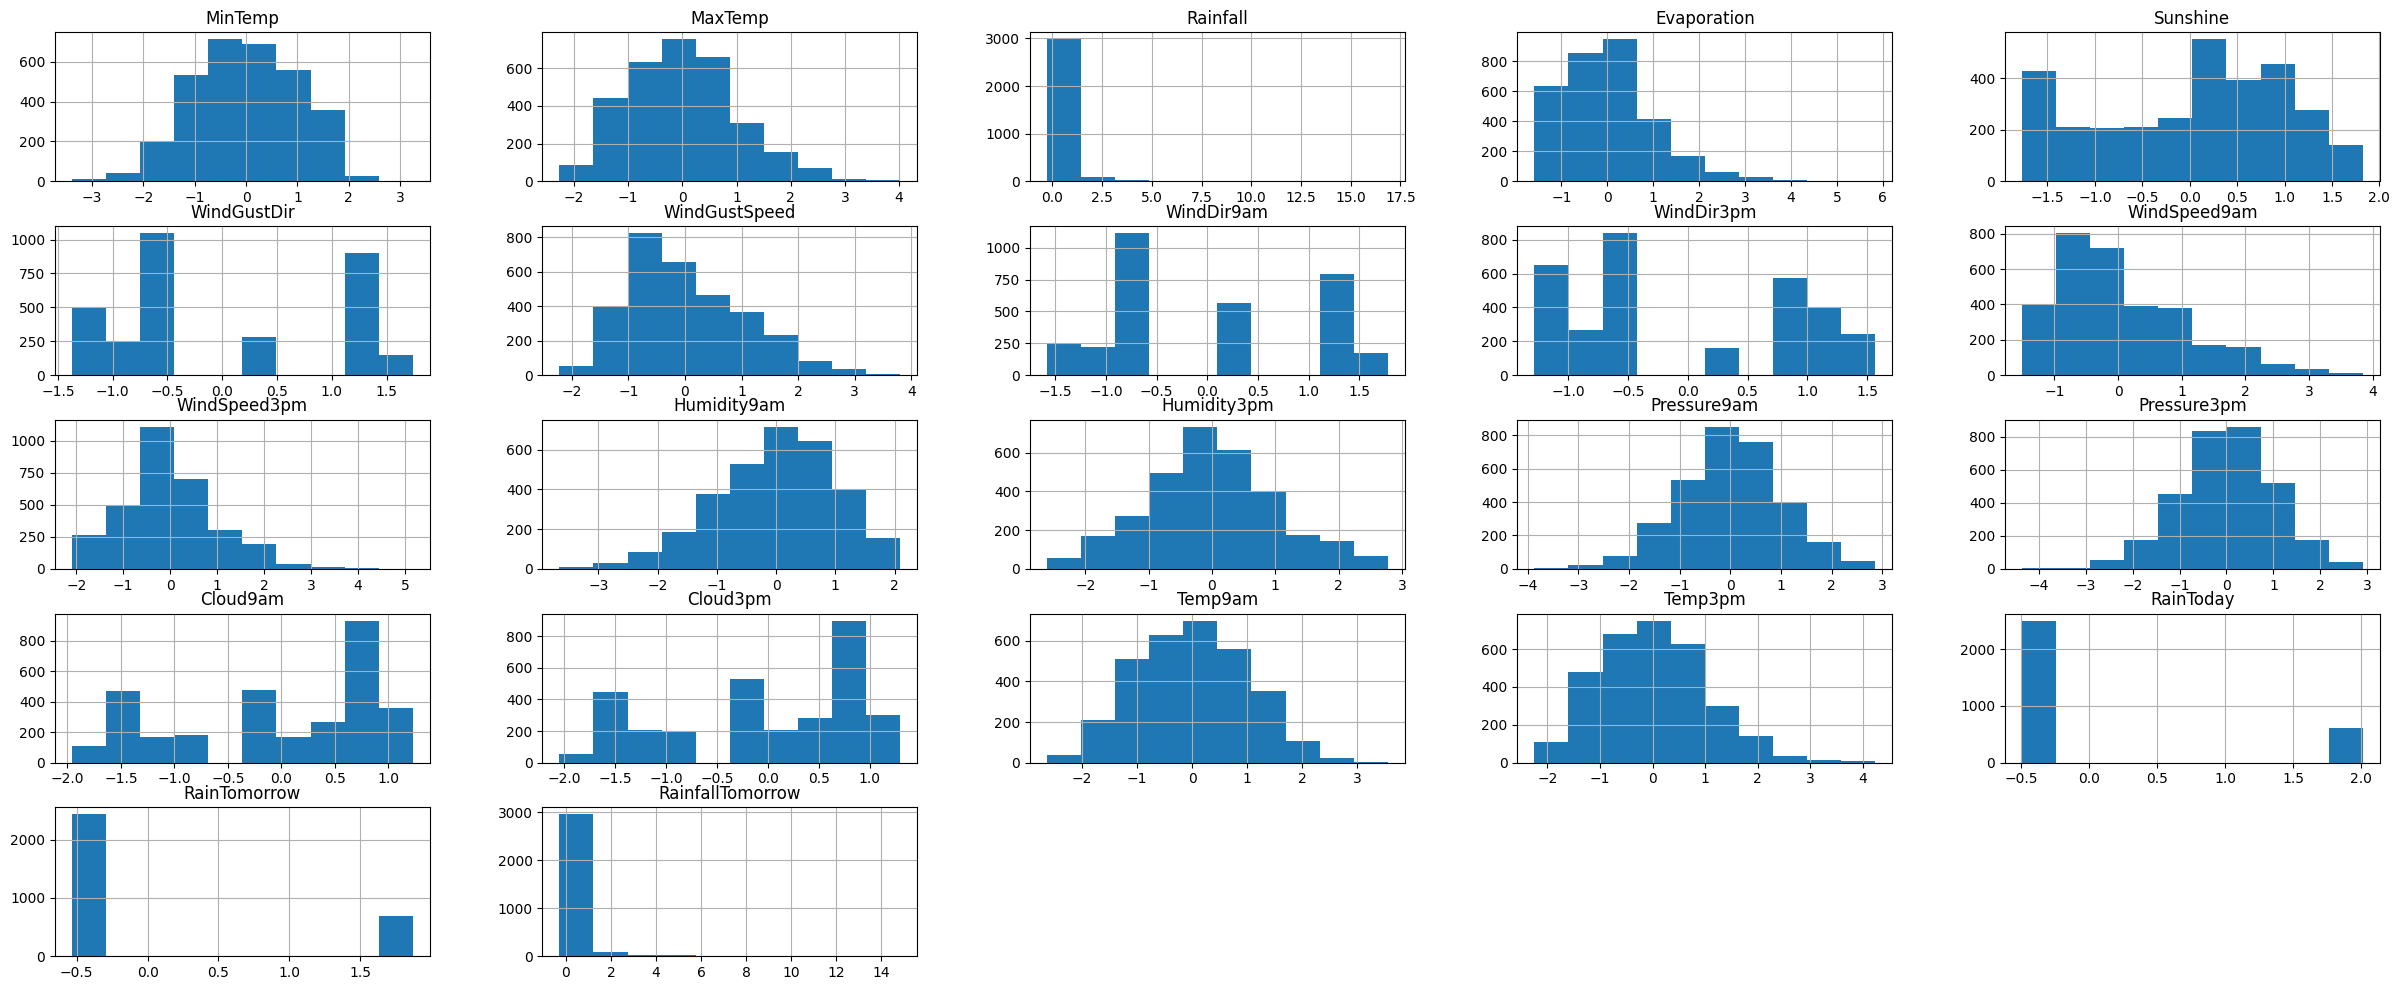

In [27]:
df_std.hist(figsize=(30,12))
plt.show()

# Regresión Lineal

## Preparación

Análisis de las distribuciones

In [28]:
columnas = [col for col in df_std.columns if ((col != 'RainTomorrow') & (col != 'RainfallTomorrow'))]

In [29]:
columnas

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday']

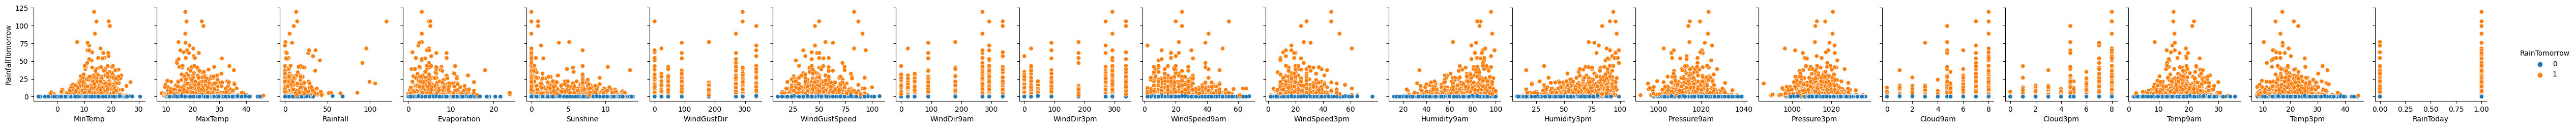

In [30]:
sns.pairplot(df, hue='RainTomorrow',x_vars=columnas,y_vars='RainfallTomorrow')
plt.show()

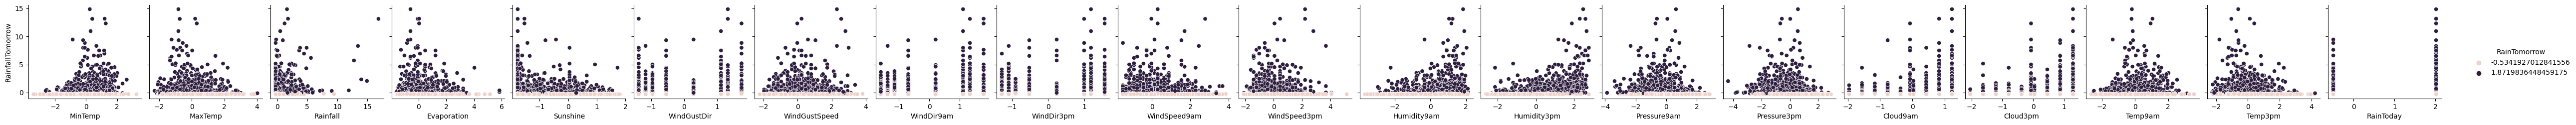

In [31]:
sns.pairplot(df_std, hue='RainTomorrow',x_vars=columnas,y_vars='RainfallTomorrow')
plt.show()

NOTA: En función de los valores de la matriz de correlación y la distribución de puntos en los gráficos, seleccionamos la variable "Humidity3pm" para analizar su relación con la variable a predecir "RainfallTomorrow".

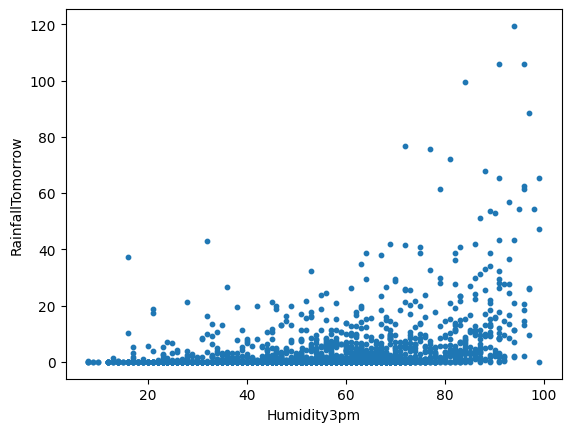

In [32]:
f ,ax = plt.subplots()
ax.scatter(df['Humidity3pm'], df['RainfallTomorrow'], s= 10)
ax.set_xlabel('Humidity3pm')
ax.set_ylabel('RainfallTomorrow')
plt.show()

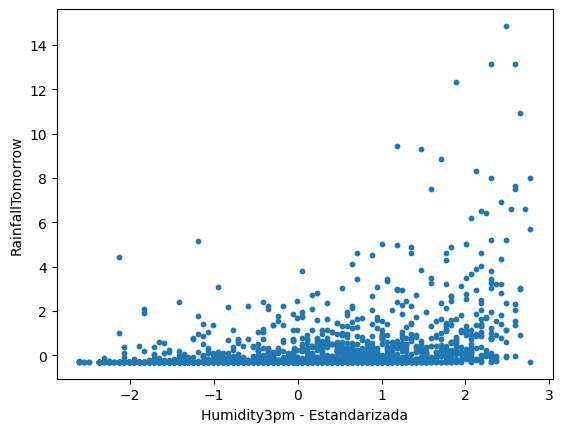

In [33]:
f ,ax = plt.subplots()
ax.scatter(df_std['Humidity3pm'], df_std['RainfallTomorrow'], s= 10)
ax.set_xlabel('Humidity3pm - Estandarizada')
ax.set_ylabel('RainfallTomorrow')
plt.show()

## Regresión lineal

In [34]:
# Datos
x, y = df_std['Humidity3pm'].values, df_std['RainfallTomorrow'].values
x.shape, y.shape

((3126,), (3126,))

In [35]:
x = x.reshape((-1,1))
y = y.reshape((-1,1))

In [36]:
# Train / Test
X_train, X_test, y_train, y_test = train_test_split(df_std.drop('RainfallTomorrow', axis=1),
                                             df_std['RainfallTomorrow'].values.reshape(-1,1),
                                             test_size=0.2,
                                             random_state=12,
                                             )

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2500, 21), (626, 21), (2500, 1), (626, 1))

In [38]:
b = np.dot(np.dot(X_train.T,X_train)**(-1), np.dot(X_train.T,y_train))

In [39]:
b.shape, b

((21, 1),
 array([[ 52.7395861 ],
        [-27.25857994],
        [ 20.91927444],
        [ 17.70041615],
        [-23.2118575 ],
        [-40.57531389],
        [ 35.41419801],
        [-30.63442851],
        [-53.20756485],
        [-63.31033989],
        [-22.01918141],
        [  4.98137649],
        [ 26.70591901],
        [-13.73278502],
        [-59.71082426],
        [ 15.0438463 ],
        [  9.31242878],
        [  1.99871911],
        [-22.64186616],
        [ 12.8201284 ],
        [  6.88758853]]))

In [40]:
xspace = np.linspace(0,2,100)
y_hat =  (xspace * b).reshape((2100,1))

In [41]:
y_hat.shape, xspace.shape

((2100, 1), (100,))

ValueError: ignored

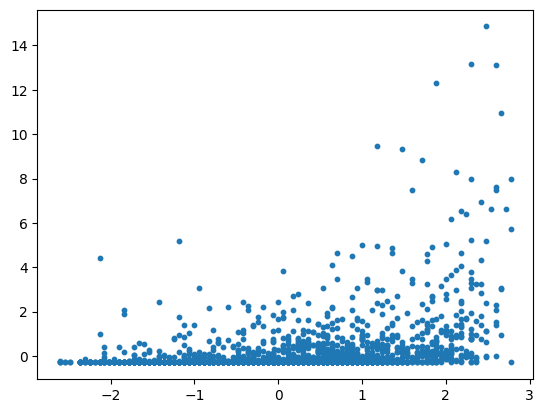

In [42]:
fig, ax = plt.subplots()
ax.scatter(x,y,s=10)
ax.plot(xspace,y_hat, color='red')

ax.set_xlabel('Humidity3pm')
ax.set_ylabel('RainfallTomorrow')
plt.show()

In [ ]:


# Crear modelos de regresión lineal, Lasso y Ridge
lr = LinearRegression()
lasso = Lasso(alpha=0.1)  # alpha controla la fuerza de la regularización L1 (Lasso)
ridge = Ridge(alpha=0.1)  # alpha controla la fuerza de la regularización L2 (Ridge)
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)

# Ajustar modelos a los datos
lr.fit(X, y)
lasso.fit(X, y)
ridge.fit(X, y)
elasticnet.fit(X, y)

# Mostrar coeficientes
print("Coeficientes del modelo de regresión lineal:")
print(lr.coef_)
print(lr.score(X,y))

print("\nCoeficientes del modelo Lasso:")
print(lasso.coef_)
print(lasso.score(X,y))


print("\nCoeficientes del modelo Ridge:")
print(ridge.coef_)
print(ridge.score(X,y))


print("\nCoeficientes del modelo ElasticNet:")
print(elasticnet.coef_)
print(elasticnet.score(X,y))


# Graficar resultados
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label='Datos de ejemplo')
plt.plot(X, lr.predict(X), label='Regresión Lineal', color='green')
plt.plot(X, lasso.predict(X), label='Lasso', color='red')
plt.plot(X, ridge.predict(X), label='Ridge', color='blue')
plt.plot(X, elasticnet.predict(X), label='ElasticNet', color='yellow')
plt.legend()
plt.title('Comparación de Regresión Lineal, Lasso y Ridge')
plt.show()

In [ ]:
lr = LinearRegression(fit_intercept=False)

In [ ]:
X_train

# PCA (Sólo para jugar un poco)

In [ ]:
# Obtener todas las componentes principales
#pca = PCA(n_components = df_std.shape[1])
pca = PCA(n_components = 7)

pca_features = pca.fit_transform(df_std)

# PC dataframe
pca_df = pd.DataFrame(
    data=pca_features,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
pca_df['RainfallTomorrow'] = df['RainfallTomorrow']

In [ ]:
pca_df